### Case Study: COVID-19 Evolution in Mexico City & Correlation with Proximity Retailing Activity

##### 0.0 - Section Description

insert description!!!

##### 0.1 - Libraries, API keys, Configuration & Data Loading



In [1]:
#Libraries
import pandas as pd
import numpy as np
import geopandas as gpd #GIS dependency for spatial data manipulation
from datetime import datetime
import matplotlib.pyplot as plt
import requests
import plotly.express as px #to create interactive maps

#API keys
#from api_keys import gkey

#Data
covid = pd.read_csv("../Resources/covid_19_por_colonia_y_fecha.csv") #Covid cases by neighbourghood (Mexico City)
colonias = gpd.read_file("../Resources/coloniascdmx/coloniascdmx.shp") #Shapefile w/ Mexico City neighbourhoods

##### 1.1 Cleaning & Descriptive Data Analysis

In [2]:
#Basic exploration of Covid df
#The df contains observations of active covid-19 cases by Mexico City Neighbourhood since the beginning of the Pandemic.
covid = covid.rename(columns= {"Clave" : "cve_col"})
len(covid) #over 84,000 observations
len(covid["cve_col"].unique()) #1496 unique neighbourhoods
len(covid["Fecha"].unique()) #184 days reported
184*1496 #Not entries for all neighbourhoods at all days (otherwise we should have a 275,000 row df)
covid.head()

cve_col   Fecha  Casos positivos
0  05-011  200630                6
1  05-011  200903                8
2  05-011  200904                8
3  05-011  200905                7
4  05-011  200906                7

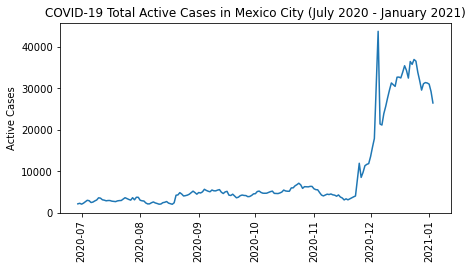

In [3]:
#Evolution of total active cases in Mexico City over time.
#group total cases by date
covid_grouped = pd.DataFrame({"Total Cases" : covid.groupby("Fecha")["Casos positivos"].sum()}).reset_index()
covid_grouped["Fecha"] = pd.to_datetime(covid_grouped["Fecha"], format= "%y%m%d")

#plotting
plt.figure(figsize= [7,3.5])
plt.plot(covid_grouped["Fecha"], covid_grouped["Total Cases"])
plt.title("COVID-19 Total Active Cases in Mexico City (July 2020 - January 2021)")
plt.ylabel("Active Cases")
plt.xticks(rotation='vertical')
plt.show()

None


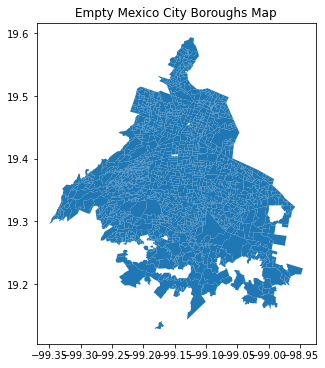

In [4]:
#Mexico City Map
print(colonias.crs)
colonias.plot(figsize= [5,10])
plt.title("Empty Mexico City Boroughs Map")
plt.show()

In [5]:
#GROUP BY ALCALDIA

covidQ3 = covid.loc[(covid["Fecha"] >= 200701) & (covid["Fecha"] < 201001),]
covidQ4 = covid.loc[(covid["Fecha"] >= 201001) & (covid["Fecha"] < 210101),]

colonias_covidQ3 = pd.merge(colonias, covidQ3, on= "cve_col", how= "left")
colonias_covidQ3 = colonias_covidQ3.drop(columns= ["id", "entidad", "cve_alc" , "secc_com", "secc_par"])
colonias_covidQ3 = colonias_covidQ3.groupby(["alcaldia", "Fecha"])["Casos positivos"].agg(["sum", "max", "mean"])
colonias_covidQ3 = colonias_covidQ3.groupby("alcaldia")["sum"].mean()
colonias_covidQ3

colonias_covidQ4 = pd.merge(colonias, covidQ4, on= "cve_col", how= "left")
colonias_covidQ4 = colonias_covidQ4.drop(columns= ["id", "entidad", "cve_alc" , "secc_com", "secc_par"])
colonias_covidQ4 = colonias_covidQ4.groupby(["alcaldia", "Fecha"])["Casos positivos"].agg(["sum", "max", "mean"])
colonias_covidQ4 = colonias_covidQ4.groupby("alcaldia")["sum"].mean()


In [6]:
colonias
colonias = colonias.dropna(subset= ["geometry"])
alcaldias = colonias.dissolve(by= "alcaldia")
alcaldias = alcaldias.drop(columns = ["id", "entidad", "cve_alc" , "secc_com", "secc_par", "nombre", "cve_col"])

df = pd.DataFrame({"q3" : colonias_covidQ3,
                  "q4": colonias_covidQ4})

alcaldias["Q3_avg_active_cases"] = round(df["q3"],0)
alcaldias["Q4_avg_active_cases"] = round(df["q4"],0)
alcaldias

geometry  \
alcaldia                                                                    
ALVARO OBREGON          POLYGON ((-99.26806 19.31272, -99.26813 19.312...   
AZCAPOTZALCO            POLYGON ((-99.14305 19.46564, -99.14303 19.465...   
BENITO JUAREZ           POLYGON ((-99.15670 19.35790, -99.15714 19.357...   
COYOACAN                POLYGON ((-99.10615 19.29963, -99.10643 19.299...   
CUAJIMALPA DE MORELOS   POLYGON ((-99.33868 19.30374, -99.33892 19.303...   
CUAUHTEMOC              POLYGON ((-99.15529 19.40534, -99.15537 19.404...   
GUSTAVO A. MADERO       POLYGON ((-99.06398 19.44544, -99.06410 19.445...   
IZTACALCO               POLYGON ((-99.12412 19.37597, -99.12448 19.376...   
IZTAPALAPA              POLYGON ((-99.07450 19.28933, -99.07504 19.289...   
LA MAGDALENA CONTRERAS  POLYGON ((-99.24401 19.27578, -99.24387 19.275...   
MIGUEL HIDALGO          POLYGON ((-99.22302 19.39604, -99.22366 19.395...   
MILPA ALTA              MULTIPOLYGON (((-98.98790 19.16988, -98.98616 ...   
TLAHUAC                 POLYGON ((-98.96699 19.20748, -98.96706 19.207...   
TLALPAN                 MULTIPOLYGON (((-99.17118 19.13304, -99.17193 ...   
VENUSTIANO CARRANZA     POLYGON ((-99.08363 19.40739, -99.08556 19.407...   
XOCHIMILCO              POLYGON ((-99.10753 19.19329, -99.10751 19.192...   

                        Q3_avg_active_cases  Q4_avg_active_cases  
alcaldia                                                          
ALVARO OBREGON                        242.0               1183.0  
AZCAPOTZALCO                          152.0                532.0  
BENITO JUAREZ                          62.0                460.0  
COYOACAN                              208.0                697.0  
CUAJIMALPA DE MORELOS                 131.0                182.0  
CUAUHTEMOC                            177.0                785.0  
GUSTAVO A. MADERO                     280.0               1329.0  
IZTACALCO                             110.0                441.0  
IZTAPALAPA                            300.0               1427.0  
LA MAGDALENA CONTRERAS                276.0                503.0  
MIGUEL HIDALGO                         95.0                398.0  
MILPA ALTA                            100.0                306.0  
TLAHUAC                               200.0                730.0  
TLALPAN                               295.0                841.0  
VENUSTIANO CARRANZA                   178.0                613.0  
XOCHIMILCO                            227.0                605.0

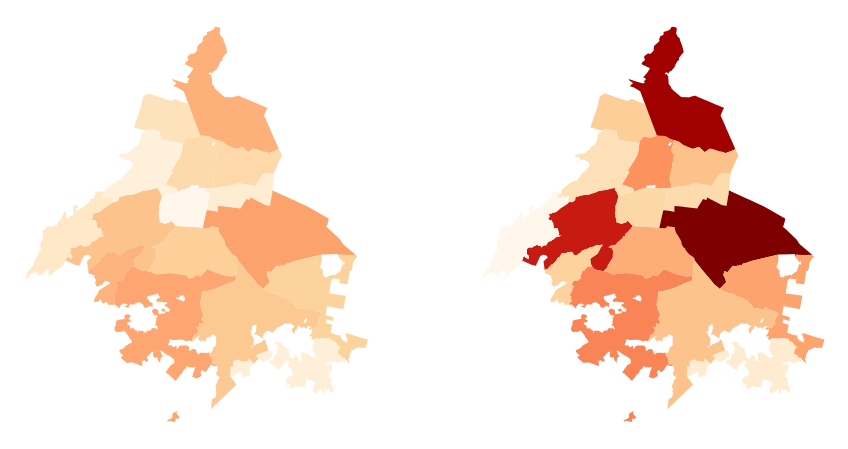

In [9]:
#Plotting 
alcaldias["avgQ3/area"] = alcaldias["Q3_avg_active_cases"] * alcaldias.area
alcaldias["avgQ4/area"] = alcaldias["Q4_avg_active_cases"] * alcaldias.area

fig2, axs = plt.subplots(1,2, figsize=(15,8))
alcaldias.plot(column= "Q3_avg_active_cases", ax= axs[0], cmap= "OrRd", 
               vmin= alcaldias["Q3_avg_active_cases"].min(), 
               vmax= alcaldias["Q3_avg_active_cases"].max() *2)
alcaldias.plot(column= "Q4_avg_active_cases", ax= axs[1], cmap= "OrRd", 
               vmin= alcaldias["Q4_avg_active_cases"].min(), 
               vmax= alcaldias["Q4_avg_active_cases"].max() )
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[1].set_axis_off()

plt.show()

In [11]:
fig2.savefig("../Results/mapa_alcaldias_casos_Q3_Q4.png")

In [12]:
covidQ3 = covid.loc[(covid["Fecha"] >= 200701) & (covid["Fecha"] < 201001),]
covidQ4 = covid.loc[(covid["Fecha"] >= 201001) & (covid["Fecha"] < 210101),]

cdmxQ3 = covidQ3.groupby("Fecha")["Casos positivos"].sum()
round(cdmxQ3.mean(),0)

cdmxQ4 = covidQ4.groupby("Fecha")["Casos positivos"].sum()
round(cdmxQ4.mean(),0)

13635.0

In [13]:
### GRIUP BY BOROUGH

covidQ3 = covid.loc[(covid["Fecha"] >= 200701) & (covid["Fecha"] < 201001),]
covidQ4 = covid.loc[(covid["Fecha"] >= 201001) & (covid["Fecha"] < 210101),]

colonias_covidQ3 = pd.merge(colonias, covidQ3, on= "cve_col", how= "left")
colonias_covidQ3 = colonias_covidQ3.drop(columns= ["id", "entidad", "cve_alc" , "secc_com", "secc_par"])
colonias_mean_covidQ3 = colonias_covidQ3.groupby(["cve_col", "Fecha"])["Casos positivos"].agg(["sum", "max", "mean"])
colonias_mean_covidQ3 = colonias_mean_covidQ3.groupby("cve_col")["sum"].mean()
colonias_mean_covidQ3 = pd.DataFrame({"Q3" : colonias_mean_covidQ3})

colonias_covidQ4 = pd.merge(colonias, covidQ4, on= "cve_col", how= "left")
colonias_covidQ4 = colonias_covidQ4.drop(columns= ["id", "entidad", "cve_alc" , "secc_com", "secc_par"])
colonias_mean_covidQ4 = colonias_covidQ4.groupby(["cve_col", "Fecha"])["Casos positivos"].agg(["sum", "max", "mean"])
colonias_mean_covidQ4 = colonias_mean_covidQ4.groupby("cve_col")["sum"].mean()
colonias_mean_covidQ4 = pd.DataFrame({"Q4" : colonias_mean_covidQ4})

colonias_main = colonias.drop(columns= ["id", "entidad", "cve_alc" , "secc_com", "secc_par"])
colonias_main = colonias_main.sort_values("cve_col")
colonias_main = pd.merge(colonias_main, colonias_mean_covidQ3, on= "cve_col", how= "left")
colonias_main = pd.merge(colonias_main, colonias_mean_covidQ4, on= "cve_col", how= "left")
colonias_main

nombre             alcaldia cve_col  \
0                    AGUILERA         AZCAPOTZALCO  02-001   
1                      ALDANA         AZCAPOTZALCO  02-002   
2        AMPLIACION PETROLERA         AZCAPOTZALCO  02-003   
3               ANGEL ZIMBRON         AZCAPOTZALCO  02-005   
4                      ARENAL         AZCAPOTZALCO  02-006   
...                       ...                  ...     ...   
1803  MOCTEZUMA 2A SECCION IV  VENUSTIANO CARRANZA  17-082   
1804                MORELOS I  VENUSTIANO CARRANZA  17-083   
1805               MORELOS II  VENUSTIANO CARRANZA  17-084   
1806      PENSADOR MEXICANO I  VENUSTIANO CARRANZA  17-085   
1807     PENSADOR MEXICANO II  VENUSTIANO CARRANZA  17-086   

                                               geometry         Q3         Q4  
0     POLYGON ((-99.15901 19.47374, -99.15882 19.473...        NaN   6.800000  
1     POLYGON ((-99.14858 19.47156, -99.14863 19.471...   9.892857   8.720000  
2     POLYGON ((-99.19667 19.48530, -99.19650 19.485...   6.666667   6.000000  
3     POLYGON ((-99.19044 19.47144, -99.19031 19.471...        NaN   8.607143  
4     POLYGON ((-99.15187 19.46803, -99.15186 19.468...   8.388889  10.418182  
...                                                 ...        ...        ...  
1803  POLYGON ((-99.09964 19.43056, -99.09858 19.430...   9.000000  20.024096  
1804  POLYGON ((-99.12379 19.43749, -99.12361 19.438...  14.867470  24.974359  
1805  POLYGON ((-99.12121 19.44797, -99.12028 19.446...  17.934066  28.506024  
1806  POLYGON ((-99.08046 19.45009, -99.08026 19.450...   6.666667  11.980392  
1807  POLYGON ((-99.08529 19.44143, -99.08529 19.440...   6.818182  12.131148  

[1808 rows x 6 columns]

/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


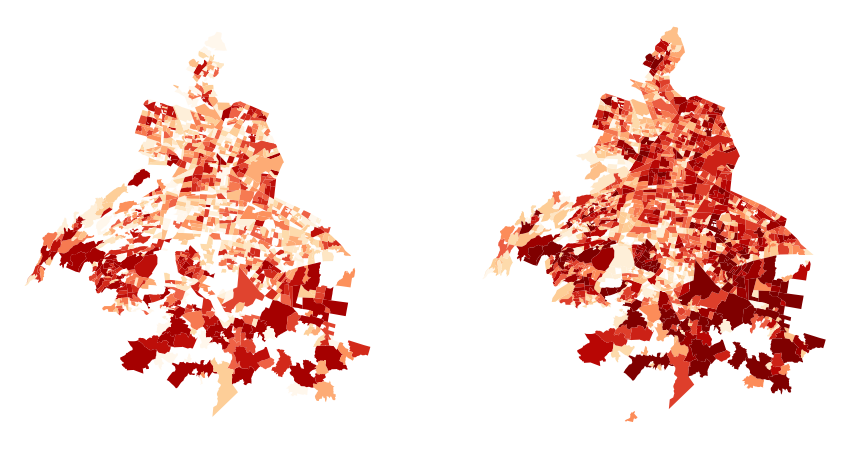

In [15]:
colonias_mainQ3 = colonias_main.dropna(subset= ["Q3"])
colonias_mainQ4= colonias_main.dropna(subset= ["Q4"])

colonias_mainQ3["cut"] = pd.qcut(colonias_mainQ3["Q3"], 15, labels= False, duplicates= "drop")
colonias_mainQ4["cut"] = pd.qcut(colonias_mainQ4["Q4"], 15, labels= False, duplicates= "drop")

fig1, axs = plt.subplots(1,2, figsize=(15,8))
colonias_mainQ3.plot(column= "cut", ax= axs[0], cmap= "OrRd", 
               vmin= colonias_mainQ3["cut"].min(), 
               vmax= colonias_mainQ3["cut"].max()*1.1)
colonias_mainQ4.plot(column= "cut", ax= axs[1], cmap= "OrRd", 
               vmin= colonias_mainQ4["cut"].min(), 
               vmax= colonias_mainQ4["cut"].max())
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[1].set_axis_off()
plt.show()

In [16]:
fig1.savefig("../Results/mapa_colonias_casos_Q3_Q4.png")

### 

Cases have gone significantly up during the las quarter of 2020. While in Q3, the boroughs with more cases where concentrated in the South of Mexico City and there where still many boroughs without reported cases, in the last quarter of the year practically all central areas of the city where impacted by a rise of Covid-19 cases, specially central areas. Now we want to verify and contrast if there is a correlation with economic activity.

##### 1.2 Looking for "tianguis" in Google Places API

The "tianguis" or local market in Mexico City is practically a long established institution. Groceries, Clothing, food, etc. are sold in local street markets on a particular day of the week. Thouthands of residents of the borough make their weekly shopping in their local "tianguis". However, those open street markets do not meet necessary social distancing measures and are supposed to be perfect places for Covid 19 transmission. Of course, open street market activities were immediately impacted by the pandemic, as shoppers shifted to other forms of grocery shopping. However, these places are still operational and highly populated, and we could potentially stablish a hypothetical correlation between  "tianguis" popoularity and covid19 cases reported in the borough where the "tianguis" takes place.


The following script line has been executed just once to retreive data from Google Places API and now has been "blocked" to prevent to execute again by mistake. The resulting df has been saved and can be uploaded in following lines.

In [473]:
###Getting "tianguis" data from Google Places --> EXECUTE JUST ONE TIME!!!

###sampling bouroughs (1812 to a just 100 to reduce amount of google queries)
#sample_colonias = coloniasQ4.sample(n= 100)
#sample_colonias = sample_colonias.reset_index()
#sample_colonias

###Looping over boroughs to find tianguis
#name = []
#vicinity = []
#rating = []
#user_ratings_total = []
#lng = []
#lat = []

#url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

#for i in range(0,len(sample_colonias)):
#    params = {
#    "location": f'{sample_colonias["geometry"].centroid[[i]].y[i]}, {sample_colonias["geometry"].centroid[[i]].x[i]}',
#    "keyword": "Tianguis",
#    "radius": 5000,
#    "key": gkey
#    }
#    response = requests.get(url, params= params).json()
#    try:
#        print(f'Looking for tianguis in query {i} - CVE COL: {sample_colonias.iloc[i,3]}.')
#        
#        for j in range(0, len(response["results"])):
#            name.append(response["results"][j]["name"])
#            vicinity.append(response["results"][j]["vicinity"])
#            rating.append(response["results"][j]["rating"])
#            user_ratings_total.append(response["results"][j]["user_ratings_total"])
#           lng.append(response["results"][j]["geometry"]["location"]["lng"])
#            lat.append(response["results"][j]["geometry"]["location"]["lat"])      
#    except:
#        print(f"(!!) Some information not found: query{i} CVE COL: {sample_colonias.iloc[i,3]}")
#        pass
#    print("-----------------------------------------")

###Creating a Tianguis dataframe
#tianguis = pd.DataFrame({
#    "name" : name,
#    "vicinity" : vicinity,
#    "rating" : rating,
#    "Users_ratings_total": user_ratings_total,
#    "lng" : lng,
#    "lat" : lat
#})

Looking for tianguis in query 0 - CVE COL: 10-002.
-----------------------------------------
Looking for tianguis in query 1 - CVE COL: 05-190.
-----------------------------------------
Looking for tianguis in query 2 - CVE COL: 05-115.
-----------------------------------------
Looking for tianguis in query 3 - CVE COL: 15-046.
-----------------------------------------
Looking for tianguis in query 4 - CVE COL: 07-315.
-----------------------------------------
Looking for tianguis in query 5 - CVE COL: 11-013.
-----------------------------------------
Looking for tianguis in query 6 - CVE COL: 14-042.
-----------------------------------------
Looking for tianguis in query 7 - CVE COL: 05-208.
-----------------------------------------
Looking for tianguis in query 8 - CVE COL: 15-006.
-----------------------------------------
Looking for tianguis in query 9 - CVE COL: 02-091.
-----------------------------------------
Looking for tianguis in query 10 - CVE COL: 17-070.
------------------

Looking for tianguis in query 88 - CVE COL: 07-091.
-----------------------------------------
Looking for tianguis in query 89 - CVE COL: 06-045.
-----------------------------------------
Looking for tianguis in query 90 - CVE COL: 10-121.
-----------------------------------------
Looking for tianguis in query 91 - CVE COL: 16-094.
-----------------------------------------
Looking for tianguis in query 92 - CVE COL: 05-016.
-----------------------------------------
Looking for tianguis in query 93 - CVE COL: 12-117.
-----------------------------------------
Looking for tianguis in query 94 - CVE COL: 15-029.
-----------------------------------------
Looking for tianguis in query 95 - CVE COL: 12-145.
-----------------------------------------
Looking for tianguis in query 96 - CVE COL: 17-037.
-----------------------------------------
Looking for tianguis in query 97 - CVE COL: 05-003.
-----------------------------------------
Looking for tianguis in query 98 - CVE COL: 03-088.
--------

In [42]:
#tianguis
#tianguis_copy = tianguis
#tianguis_copy= tianguis_copy.drop_duplicates()
#tianguis_copy.to_csv("Results/tianguis_df.csv")

In [17]:
tianguis = pd.read_csv("../Results/tianguis_df.csv")

#Tianguis heatmap

fig = px.scatter_mapbox(tianguis, lat="lat", lon="lng", zoom= 10, color_continuous_scale= "inferno",  
                        text= "name", size= "Users_ratings_total", color= "Users_ratings_total")
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

##### 1.3 - Assigining Tianguis to Townships (alcaldias)

In [19]:
#transforming tianguis into gpd
tianguis = gpd.GeoDataFrame(tianguis, geometry= gpd.points_from_xy(tianguis.lat, tianguis.lng))
alcaldias_tianguis = gpd.read_file("../Results/alcaldias_con_tianguis.geojson")

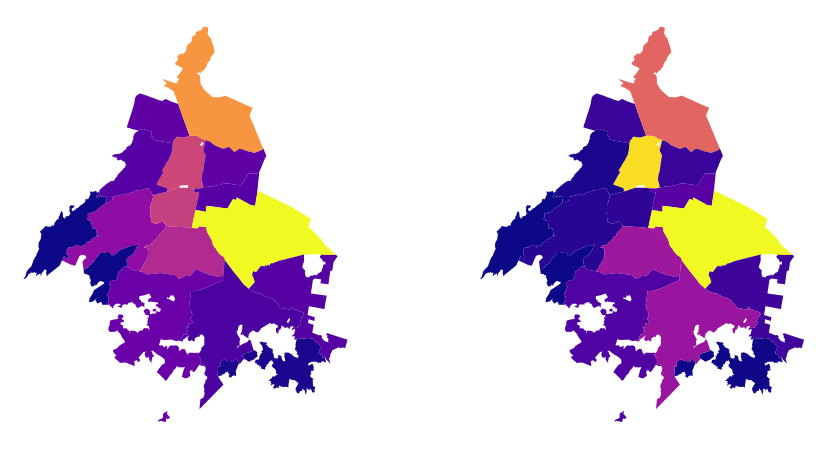

In [24]:
fig4, axs = plt.subplots(1,2, figsize=(15,8))
alcaldias_tianguis.plot(column= "tianguis_count", ax= axs[0], cmap= "plasma")
alcaldias_tianguis.plot(column= "tianguis_tot_ratings", ax= axs[1], cmap= "plasma")
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[1].set_axis_off()
plt.show()

fig2.savefig("../Results/tianguis_count_and_popularity_by_district.png")

In [38]:
alcaldias_tianguis

alcaldia  tianguis_count  tianguis_tot_ratings  \
0           ALVARO OBREGON              12                 912.0   
1             AZCAPOTZALCO               7                1790.0   
2            BENITO JUAREZ              19                1221.0   
3                 COYOACAN              16                7152.0   
4    CUAJIMALPA DE MORELOS               0                   0.0   
5               CUAUHTEMOC              20               19716.0   
6        GUSTAVO A. MADERO              30               12774.0   
7                IZTACALCO               6                3329.0   
8               IZTAPALAPA              40               21195.0   
9   LA MAGDALENA CONTRERAS               0                   0.0   
10          MIGUEL HIDALGO               6                 513.0   
11              MILPA ALTA               1                 151.0   
12                 TLAHUAC               6                1978.0   
13                 TLALPAN               8                2974.0   
14     VENUSTIANO CARRANZA               7                1703.0   
15              XOCHIMILCO               5                6917.0   

    tianguis_avg_ratings                                           geometry  
0                   76.0  POLYGON ((-99.20003 19.33324, -99.19867 19.333...  
1                  255.7  POLYGON ((-99.14614 19.46743, -99.14586 19.467...  
2                   64.3  POLYGON ((-99.13956 19.35958, -99.13957 19.359...  
3                  447.0  POLYGON ((-99.10028 19.30646, -99.10045 19.304...  
4                    0.0  POLYGON ((-99.33793 19.30417, -99.33802 19.304...  
5                  985.8  POLYGON ((-99.12617 19.40682, -99.12583 19.405...  
6                  425.8  POLYGON ((-99.06224 19.44485, -99.06250 19.444...  
7                  554.8  POLYGON ((-99.05938 19.39230, -99.05945 19.391...  
8                  529.9  POLYGON ((-99.04527 19.31339, -99.04573 19.312...  
9                    0.0  POLYGON ((-99.24493 19.27638, -99.24474 19.276...  
10                  85.5  POLYGON ((-99.17100 19.40269, -99.17100 19.402...  
11                 151.0  MULTIPOLYGON (((-99.10211 19.20099, -99.10159 ...  
12                 329.7  POLYGON ((-99.01336 19.26293, -99.01436 19.263...  
13                 371.8  MULTIPOLYGON (((-99.16890 19.13512, -99.16734 ...  
14                 243.3  POLYGON ((-99.07984 19.40691, -99.08019 19.406...  
15                1383.4  POLYGON ((-99.14692 19.23406, -99.14689 19.234...